In [55]:
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(tidymodels)
options(repr.matrix.max.rows = 6)

<h2>Introduction</h2> 

<h4>Background Information</h4>  

We are interested in what player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how these  
features differ between various player types. Specifically, we are interested in if **a player's total playtime and age can predict if that player is  
subscribed to a game-related newsletter or not**. In order to carry out our analysis, we must load the data in and make changes to the data so that it  
is formatted appropriately. This also allows us to properly visualize the data which helps us navigate through our analysis as well as convey information.  
With the properly formatted data and the information provided by the visualizations, we can perform the data analysis. More specifically, we  
will be able to create an algorithm that tries to categorize if a player is subscribed to a game-related newsletter based on total playtime and age.  
This algorithm can be trained and tested and its accuracy will help us come to a conclusion. Additional visualizations will help convey the reasoning  
behind our conclusion.

<h4>Data Description</h4>

Datasets provided for the analysis are **sessions.csv** and **players.csv**

Dataset **sessions.csv** contains data for unique play sessions including the session start and end times and a string unique to each player.  
The columns in this data set are:
1. **hashedEmail**: string variable unique for the player
2. **start_time**: character variable indicating date and time of start of session
3. **end_time**: character variable indicating date and time of end of session
4. **original_start_time**: numeric variable indicating start time of session in unknown format
5. **original_end_time**: numeric variable indicating end time of session in unknown format

Dataset **players.csv** contains data for each unique player including personal and game-related information.  
The columns in this data set are:
1. **experience**: categorical variable stating the experience level of the player
2. **subscribe**: boolean variable stating if the player is subscribed to a game-related newsletter
3. **hashedEmail**: string variable unique for the player
4. **played_hours**: numeric variable stating total hours played for the player
5. **name**: string variable stating the name of the player
6. **gender**: string variable stating the gender of the player
7. **Age**: numeric variable stating the age of the player

<h2>Methods & Results</h2>

<h4>Data Wrangling</h4>

In [56]:
players <- read_csv("https://raw.githubusercontent.com/Kqvii/DSCI100-Group13/refs/heads/main/data/players.csv") |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(!is.na(Age), !is.na(played_hours), !is.na(subscribe))
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


In [57]:
players_wrangled <- players |> select(subscribe, played_hours, Age)

subscribe,subscribed,average_hours_played
<fct>,<int>,<dbl>
FALSE,52,0.5019231
TRUE,142,7.8830986


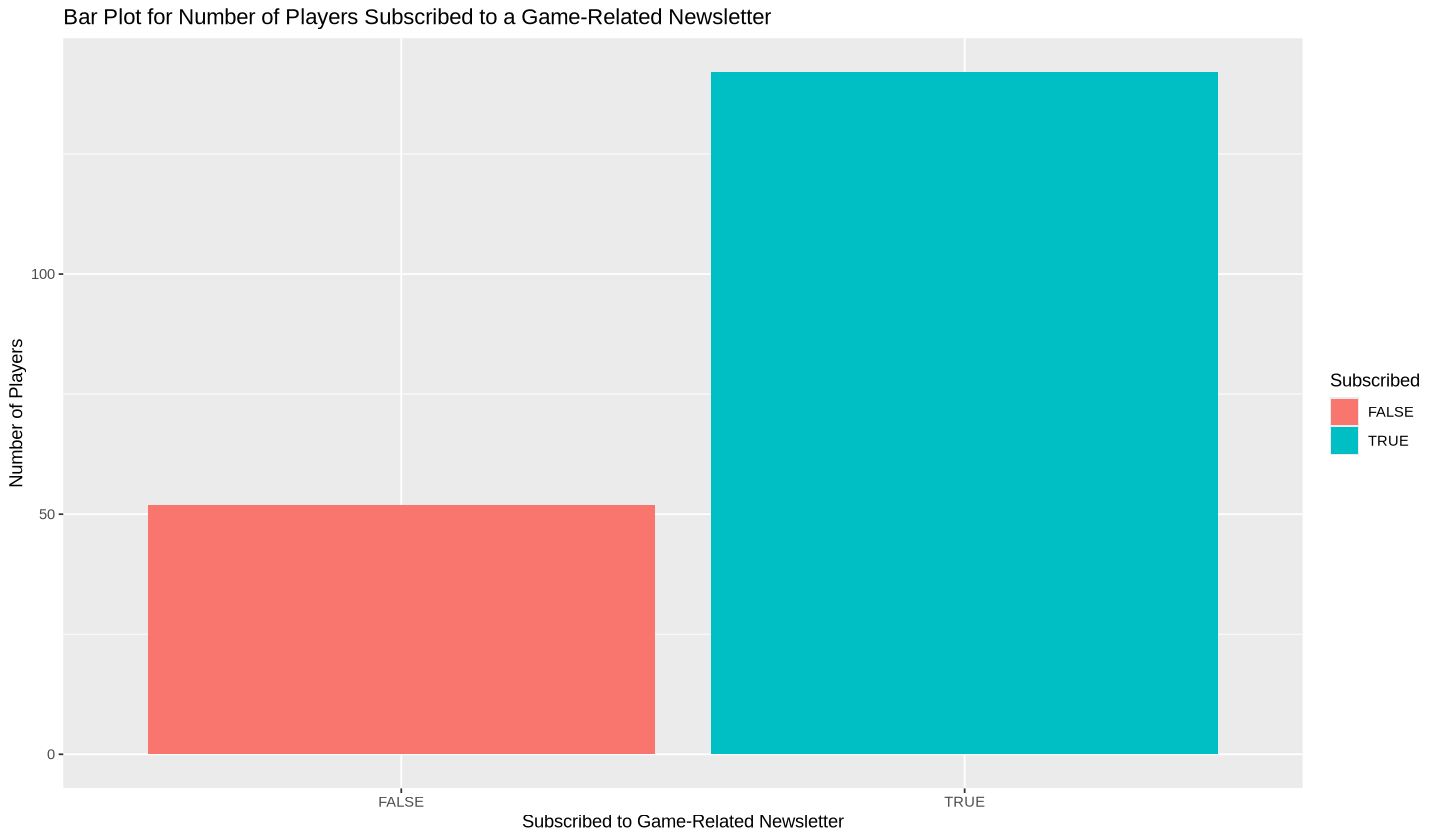

In [58]:
subscribed_viz_data <- players_wrangled |>
    group_by(subscribe) |>
    summarize(subscribed = n(),
              average_hours_played = mean(played_hours))
subscribed_viz_data

subscribed_viz <- subscribed_viz_data |>
    ggplot(aes(x = subscribe, y = subscribed, fill = subscribe)) +
        geom_bar(stat = "identity") +
        labs(x = "Subscribed to Game-Related Newsletter",
             y = "Number of Players",
             title = "Bar Plot for Number of Players Subscribed to a Game-Related Newsletter",
             fill = "Subscribed")
subscribed_viz

In [59]:
set.seed(1234)

players_split <- initial_split(players_wrangled, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)
players_train
players_test

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
FALSE,0.0,21
FALSE,0.0,22
FALSE,0.1,17
⋮,⋮,⋮
TRUE,0,17
TRUE,0,20
TRUE,0,17


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
FALSE,0.0,17
TRUE,0.1,21
⋮,⋮,⋮
TRUE,0.1,17
TRUE,0.1,44
FALSE,2.3,17


In [60]:
subscribe_recipe <- recipe(subscribe ~ played_hours + Age, data = players_wrangled) |>
  step_center(all_predictors()) |>  
  step_scale(all_predictors())

subscribe_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
      set_engine("kknn") |>
      set_mode("classification")

subscribe_fit <- workflow() |>
      add_recipe(subscribe_recipe) |>
      add_model(subscribe_model) |>
      fit(data = players_train)

In [76]:
players_predictions <- predict(subscribe_fit, players_test) |>
    bind_cols(players_test)

players_predictions

players_predictions_metrics <- players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)

players_predictions_metrics

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,30.3,9
FALSE,FALSE,0.0,17
TRUE,TRUE,0.1,21
⋮,⋮,⋮,⋮
TRUE,TRUE,0.1,17
FALSE,TRUE,0.1,44
TRUE,FALSE,2.3,17


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5714286
kap,binary,-0.0729927


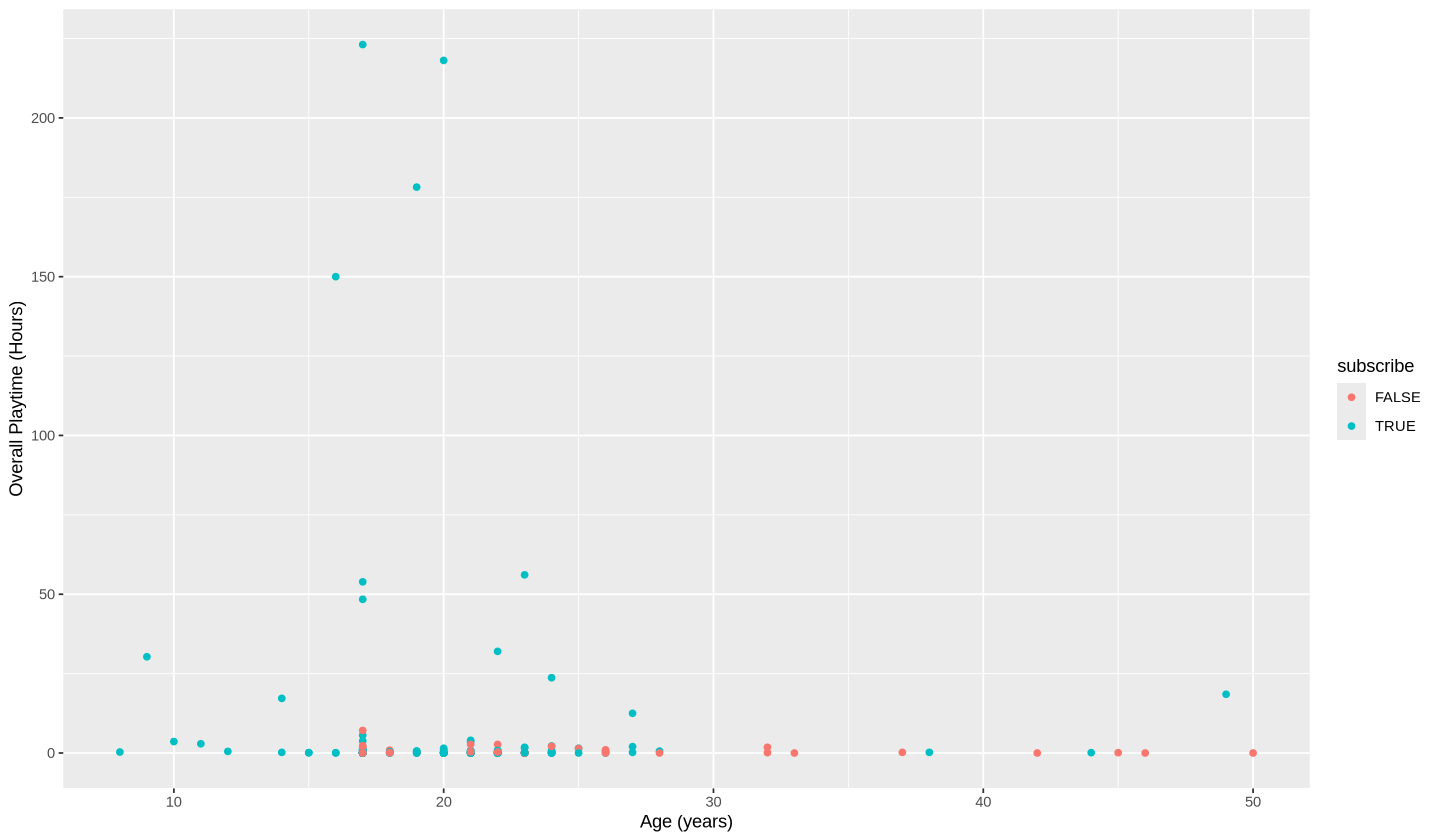

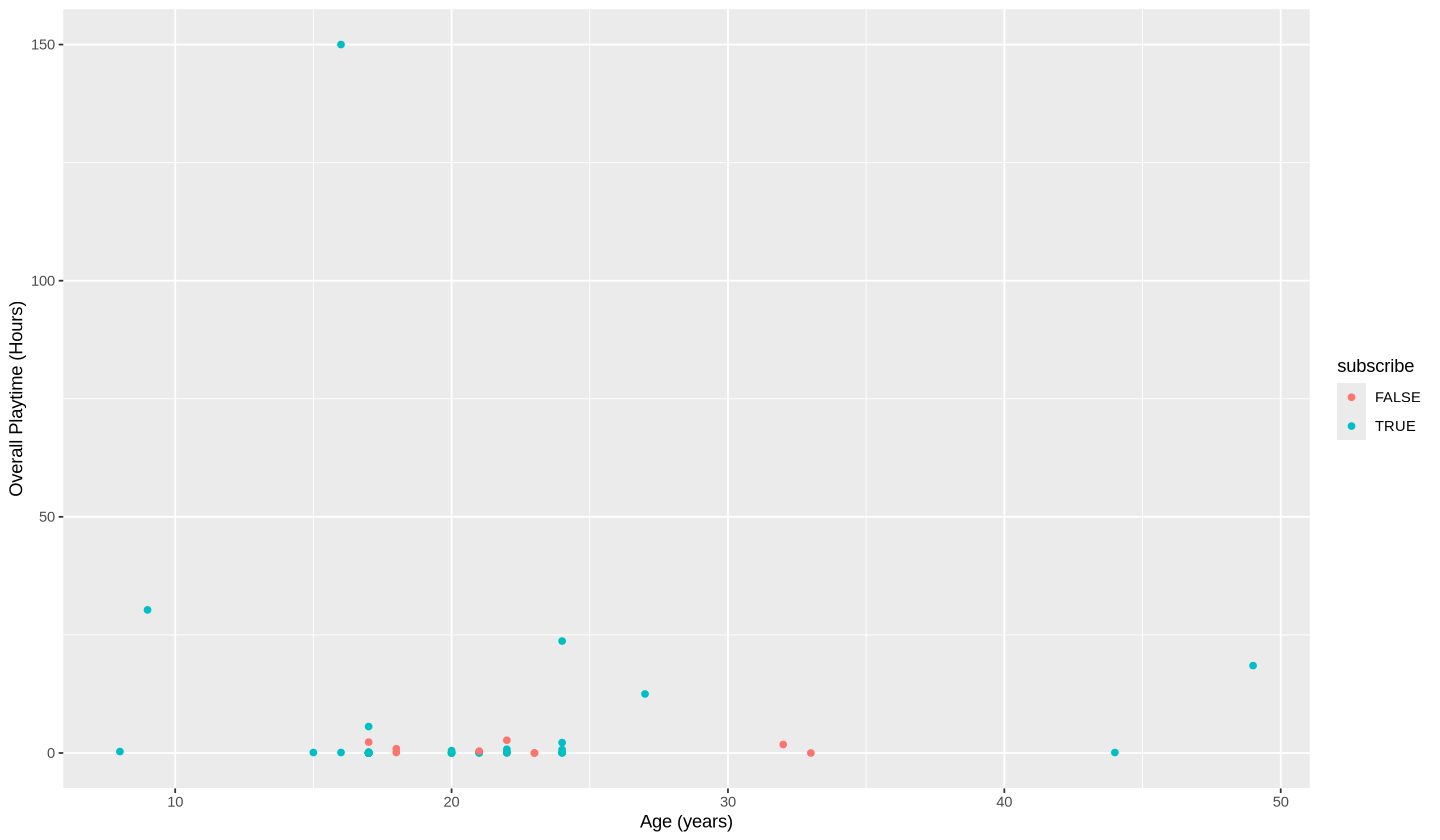

In [63]:
players_plot <- players_wrangled |>
    ggplot(aes(x = Age, y = played_hours)) + 
        geom_point(aes(colour = subscribe)) +
        xlab("Age (years)") + 
        ylab("Overall Playtime (Hours)")
players_plot


players_prediction_plot <- players_test_predictions |>
    ggplot(aes(x = Age, y = played_hours)) + 
        geom_point(aes(colour = subscribe)) +
        xlab("Age (years)") + 
        ylab("Overall Playtime (Hours)")
players_prediction_plot

Warning message:
“Removed 10 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


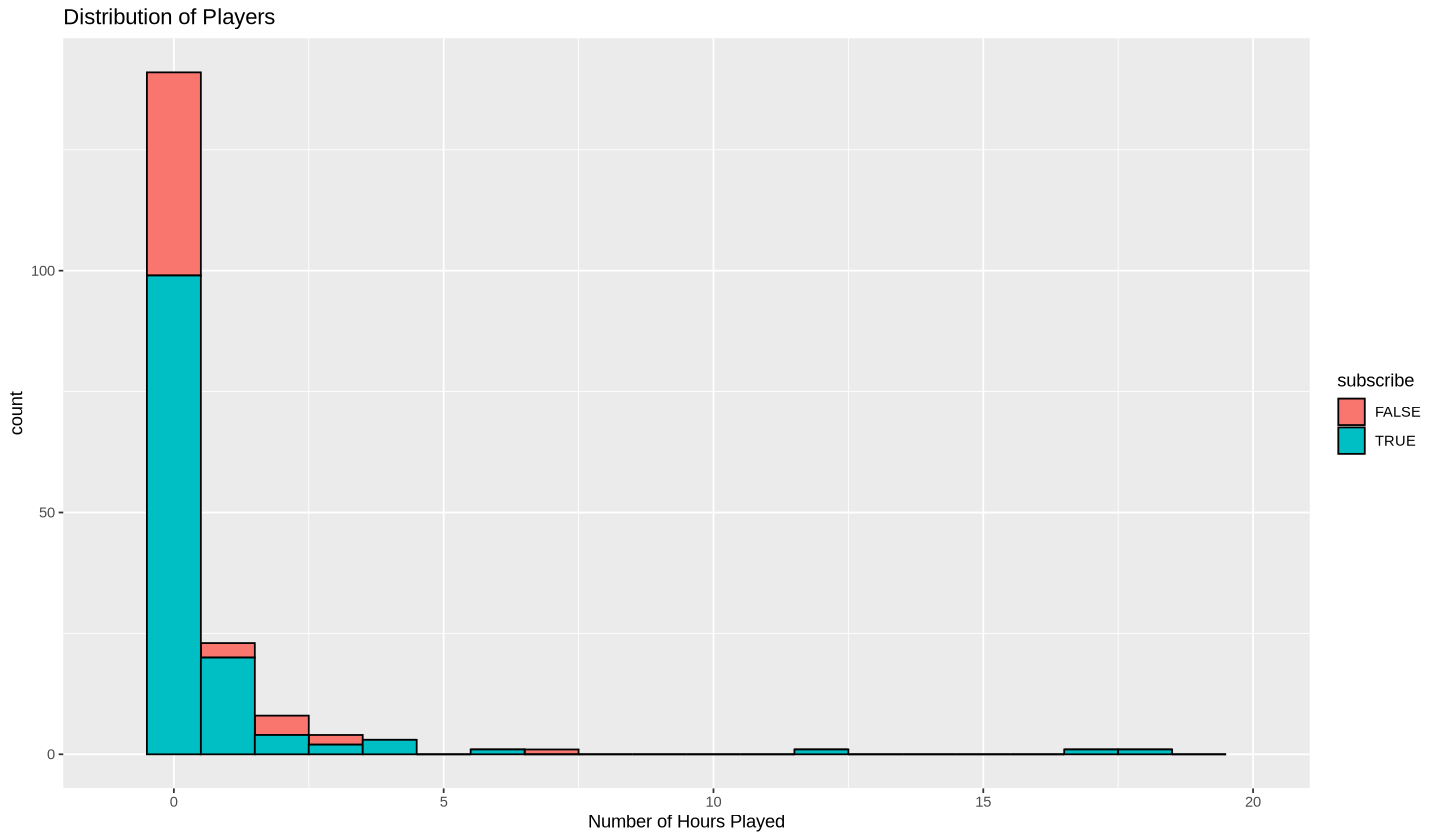

In [64]:
options(repr.plot.width=12)
players_dist <- players_wrangled |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram(binwidth = 1, color = "Black") +
    scale_x_continuous(limits = c(-1, 20)) +
    labs(x = "Number of Hours Played", title = "Distribution of Players")

players_dist

In [65]:
average_player <- players_wrangled |>
    summarize(avg_age = median(Age),
              avg_playtime = median(played_hours))
average_player

avg_age,avg_playtime
<dbl>,<dbl>
19,0.1


In [66]:
new_obs <- tibble(played_hours = 0.1,Age =19)
class_prediction <- predict(subscribe_fit, new_obs)
class_prediction

.pred_class
<fct>
TRUE


In [67]:
subscribe_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

In [68]:
players_resample_fit <- workflow() |> 
  add_recipe(subscribe_recipe) |>   
  add_model(subscribe_model) |>       
  fit_resamples(resamples = subscribe_vfold)

In [69]:
players_metrics <- collect_metrics(players_resample_fit)
players_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6333662,5,0.03274610,Preprocessor1_Model1
roc_auc,binary,0.5102505,5,0.02554028,Preprocessor1_Model1


In [70]:
players_tune <- nearest_neighbor(mode = "classification", 
                             neighbors = tune(), 
                             weight_func = "rectangular") |> 
  set_engine("kknn")

players_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [71]:
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |> 
  add_recipe(subscribe_recipe) |>  # Add preprocessing recipe
  add_model(players_tune) |>       # Add k-NN model with tuning
  tune_grid(resamples = subscribe_vfold, grid = k_vals) |>  # Perform tuning on cross-validation splits
  collect_metrics()  # Aggregate performance metrics
                 
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4889327,5,0.03571939,Preprocessor1_Model01
1,roc_auc,binary,0.5115260,5,0.03785072,Preprocessor1_Model01
2,accuracy,binary,0.4889327,5,0.03571939,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,binary,0.5102505,5,0.025540280,Preprocessor1_Model09
10,accuracy,binary,0.6262233,5,0.036667880,Preprocessor1_Model10
10,roc_auc,binary,0.5127396,5,0.006909878,Preprocessor1_Model10


neighbors,mean
<dbl>,<dbl>
7,0.6409688
8,0.6338424
9,0.6333662
⋮,⋮
3,0.5243842
1,0.4889327
2,0.4889327


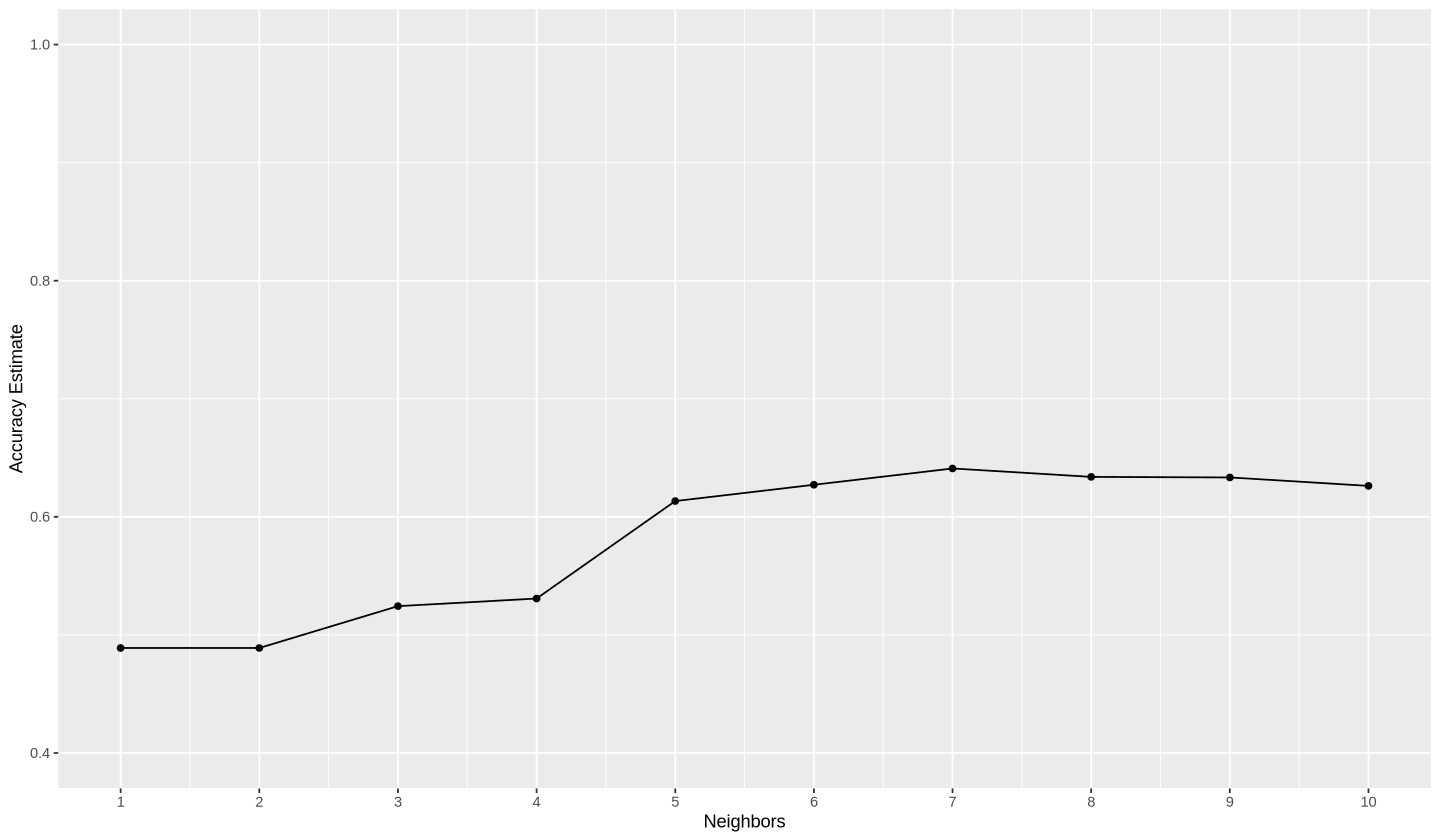

In [72]:
accuracies <- knn_results |> 
    filter(.metric == "accuracy") |>
    select(neighbors, mean) |>
    arrange(-mean)
accuracies

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k